# Convolutional Neural Network

## Packages

In [1]:
# ----- Tensorflow -----
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras import optimizers as opt

# ----- Transfer learning -----
from keras.applications import NASNetLarge
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2

# ----- plot -----
import matplotlib.pyplot as plt

# ----- Utility functions -----
from utils import load_data, plot_hist, plot_hist_sideways, _convert_sample

# ------ Data ------
import numpy as np


c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
data_dir = "D:/OneDrive - Syddansk Universitet/kandidat/3_semester/Maskinlæring/ds807_anvendt_maskinlæring/eksamen/exam/patch_camelyon"
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=10, batch_size=BATCH_SIZE)

## Transfer Learning
- Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.



## Feature Extraction

In [4]:
# Hyperparams
EPOCHS = 25
LEARNING_RATE = 0.001
OPTIMIZER = opt.Nadam(learning_rate = LEARNING_RATE)

### Feature extractor with MobileNetV2

#### Feature Extractor

In [5]:
# Layers for feature extraction
mobilev2_ft_extractor = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

#### Classifier

In [6]:
# Full model
x = mobilev2_ft_extractor.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobilev2 = Model(inputs = mobilev2_ft_extractor.output, outputs = output)

# Compile model
m_mobilev2.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [7]:
# Extract Features
mobilev2_fts_train = mobilev2_ft_extractor.predict(train)
mobilev2_fts_val = mobilev2_ft_extractor.predict(val)

103/103 [==============================] - 19s 182ms/step


#### Train model with mobilev2 features

In [8]:
history_mobile_v2 = m_mobilev2.fit(x = mobilev2_fts_train, y = y_train, validation_data = (mobilev2_fts_val, y_val), epochs = EPOCHS, batch_size = 32)

Epoch 1/25
820/820 [==============================] - 122s 140ms/step - loss: 0.7195 - accuracy: 0.5002 - val_loss: 0.6967 - val_accuracy: 0.5099
Epoch 2/25
820/820 [==============================] - 137s 167ms/step - loss: 0.6963 - accuracy: 0.5047 - val_loss: 0.7064 - val_accuracy: 0.4953
Epoch 3/25
820/820 [==============================] - 161s 197ms/step - loss: 0.6937 - accuracy: 0.5082 - val_loss: 0.7048 - val_accuracy: 0.3998
Epoch 4/25
820/820 [==============================] - 141s 172ms/step - loss: 0.6906 - accuracy: 0.5162 - val_loss: 0.6680 - val_accuracy: 0.4849
Epoch 5/25
820/820 [==============================] - 141s 172ms/step - loss: 0.6823 - accuracy: 0.5280 - val_loss: 0.7256 - val_accuracy: 0.3973
Epoch 6/25
820/820 [==============================] - 175s 213ms/step - loss: 0.6689 - accuracy: 0.5483 - val_loss: 0.7186 - val_accuracy: 0.4556
Epoch 7/25
820/820 [==============================] - 204s 248ms/step - loss: 0.6499 - accuracy: 0.5702 - val_loss: 0.6751 -

### Plot Results

#### MobileNet V2

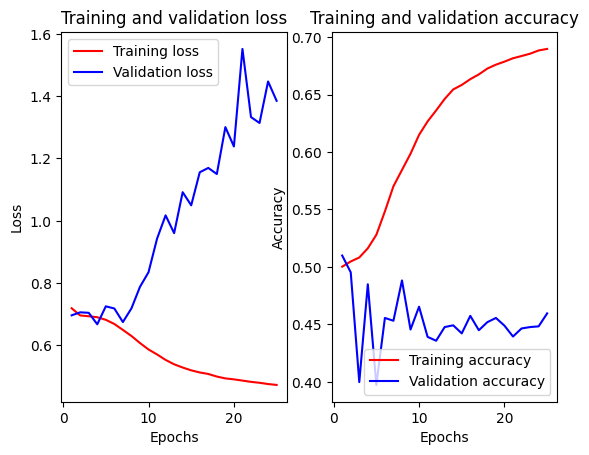

In [9]:
plot_hist_sideways(history_mobile_v2)

## Feature Extraction with multiple passes
Rather than only passing the images through once, we will feed the data through the feature extraction multiple times, we are essentially treating the transfer model as a layer, this allows us to use data augmentation

#### MobileNet V2

In [10]:
# Build classifer
inputs = Input(shape = (96, 96, 3))
x = mobilev2_ft_extractor(inputs)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobile_layer = Model(inputs = inputs, outputs = output)

# Compile model
m_mobile_layer.compile(
    optimizer = OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

In [11]:
history_mobile_layer = m_mobile_layer.fit(train, validation_data = val, epochs = EPOCHS)

Epoch 1/25
820/820 [==============================] - 894s 935ms/step - loss: 0.6533 - accuracy: 0.8320 - val_loss: 0.3922 - val_accuracy: 0.8273
Epoch 2/25
820/820 [==============================] - 692s 842ms/step - loss: 0.2828 - accuracy: 0.8777 - val_loss: 0.4242 - val_accuracy: 0.8123
Epoch 3/25
820/820 [==============================] - 678s 826ms/step - loss: 0.2301 - accuracy: 0.9036 - val_loss: 0.4166 - val_accuracy: 0.8316
Epoch 4/25
820/820 [==============================] - 680s 829ms/step - loss: 0.1867 - accuracy: 0.9235 - val_loss: 0.6022 - val_accuracy: 0.7821
Epoch 5/25
820/820 [==============================] - 682s 831ms/step - loss: 0.1497 - accuracy: 0.9387 - val_loss: 0.6282 - val_accuracy: 0.7992
Epoch 6/25
820/820 [==============================] - 682s 831ms/step - loss: 0.1262 - accuracy: 0.9496 - val_loss: 0.8108 - val_accuracy: 0.7772
Epoch 7/25
820/820 [==============================] - 629s 766ms/step - loss: 0.1062 - accuracy: 0.9585 - val_loss: 0.7208 -

### Plot results

#### MobileNet

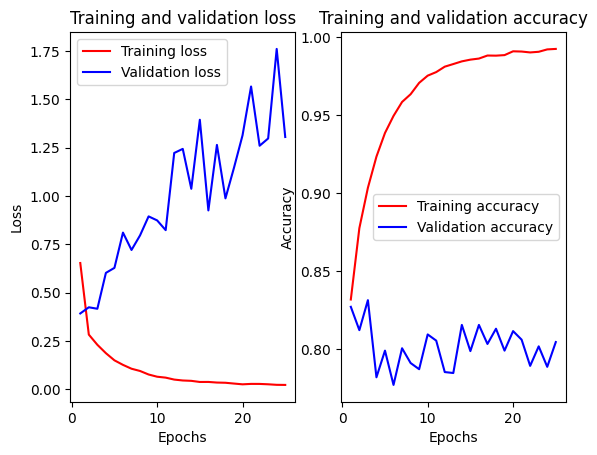

In [12]:
plot_hist_sideways(history_mobile_layer)